### 01. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 02. Setting up the pricing enviroment 

In [3]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t): # p_t is price, n_t is the number of people who see the product. t is the round
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

The conversion probability is adapted to the project: in this case the prices have to be in the range [0, 1]. Then, the conversion probability has to be changed.
**Later, we will need to change the round part to put the number of people that comes from the ads**

### 03. Setting up the RBF Gaussian Processes (exactly the same as the professor)

In [4]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

### 04. GP-UCB Agent setting

$UCB_t(a) = \mu_{t-1}(a) + \beta_t\sigma_{t-1}(a)$, for $ a\in [0,1]$ (continuous action set).

$\beta_t$ is the parameter governing exploration. It accounts for two main factors: $\gamma_t$, which represents the maximum information that can be gained at round $t$, and a term in the order of $\mathcal{O}(\sqrt{\log(T)})$ that incentivizes exploration (in a similar way as UCB1).

In this part, there are some costumizable parameters: 
* Scale can be [0, 0.1, ..., 2]
* B can be 0.5 or 1

In [5]:

# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.

scale_parameter = 2
B_parameter = 1

class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale= scale_parameter).fit()     # TRY DIFFERENT VALUES BETWEEN 0 AND 1
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: B_parameter + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))      # The first 1 comes from a formula in which that 1 is B. B would be the upper-bound of the rewards. The 0.5 is the sigma to be used; if you are not sure, it is better to use 1 instead of 0.5.
        self.N_pulls = np.zeros(discretization)                                         # Gamma is a term used to refer to the maximum information that can be gained. It has a formula calculated above
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

### 05. GP-UCB Agent Cumulative regret computation (just 1 agent)

In [19]:
T = 1000
n_customers = 200
cost = 0.1


epsilon = T**(-0.33)
K = 1000
prices = np.linspace(0,1,K)

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/1
reward_function = lambda price, n_sales: (price-cost)*n_sales

min_price, max_price = 0, 1
cost = 0.1
agent = GPUCBAgent(T, discretization=K)
np.random.seed(10)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    # p_t = rescale(p_t, min_price, max_price)      # ++ In this case is not needed as prices are already in the range [0, 1]
    d_t, r_t = env.round(p_t, n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
average_regret = cumulative_regret/np.arange(1, len(cumulative_regret)+1)

### 06. Estimated profit curve

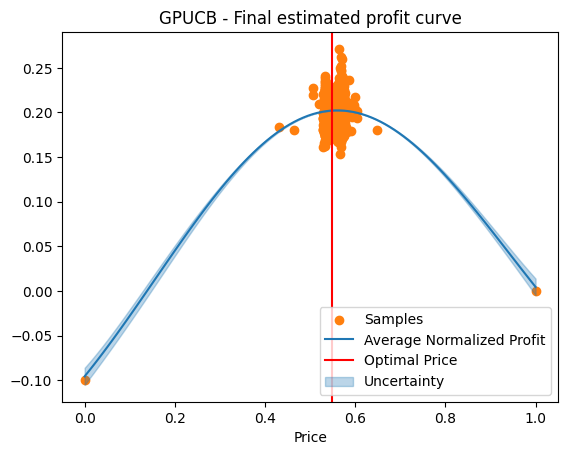

In [20]:
prices_used = rescale(agent.action_hist, min_price, max_price)  # ++ Changed de "prices" variable name to "prices_used". The rescale part is not necessary
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2) 
gp.fit(prices_used, profits)
mu, sigma = gp.predict(np.linspace(0,1,100))
plt.scatter(prices_used, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve')
plt.xlabel('Price')
plt.legend()
plt.show()

### 07. Cumulative regret plot

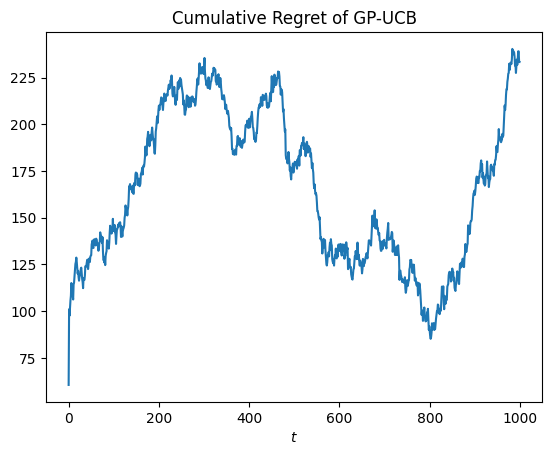

In [21]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

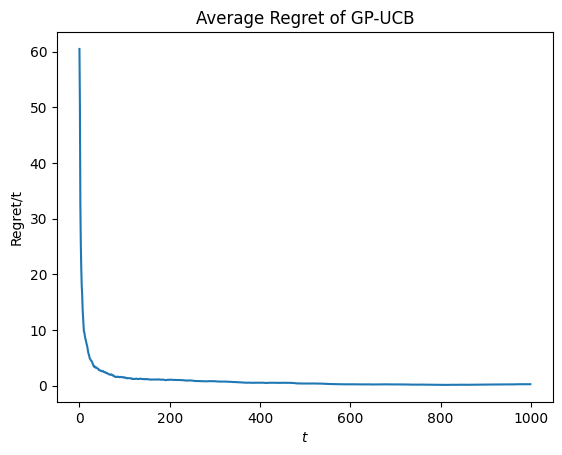

In [22]:
plt.figure()
plt.plot(average_regret)
plt.title('Average Regret of GP-UCB')
plt.xlabel('$t$')
plt.ylabel("Regret/t")
plt.show();

### 08. Multiple estimations

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


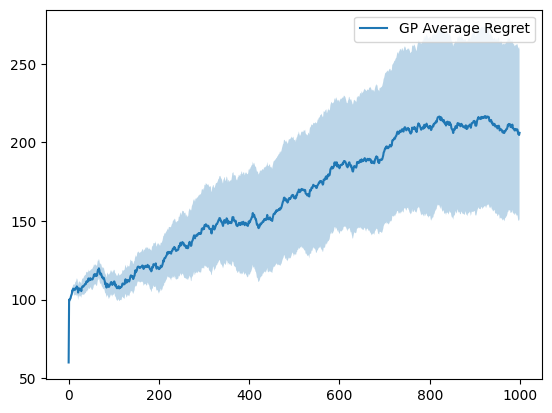

In [23]:
T = 1000
min_price, max_price = 0, 1
n_customers = 200
cost = 0.1

# Computation of best k
epsilon = T**(-0.33)
K = int(1/epsilon)


def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/1
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible theorical reward is selling at the maximum price to every possible customer. But that is not realistic


# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 10

gp_all_cumulative_regrets = []

for i in range(n_epochs):
    print(round(i/n_epochs, 4)*100)
    gp_agent = GPUCBAgent(T, discretization=K)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])

    for t in range(T):
        p_t = gp_agent.pull_arm()
        # p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)


    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))


gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)

plt.legend()
plt.show();

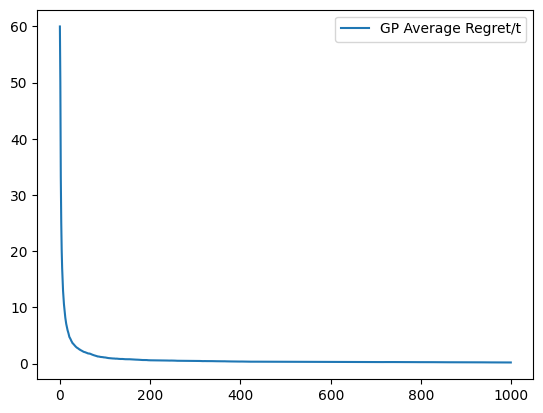

In [24]:
mean_gp_average_cumulative_regret = gp_average_cumulative_regret/np.arange(1, T+1)
plt.plot(np.arange(T), mean_gp_average_cumulative_regret, label='GP Average Regret/t')

plt.legend()
plt.show();